PyTorch with Metal Performance Shaders (MPS) is a better choice than JAX for GPU-accelerated training. Here’s why:
	1.	Native Support for Apple Silicon GPUs:
PyTorch’s MPS backend directly uses the GPU on M2 Pro, making it faster than CPU-bound JAX on macOS.
	2.	Simpler Workflow:
With PyTorch, models can be trained and deployed without needing conversions (e.g., JAX -> TensorFlow -> Core ML).
	3.	Versatile Ecosystem:
PyTorch is widely used, well-documented, and supports almost all ML tasks, including your neural network for QKD.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import json
from tqdm import tqdm
import torch.nn.functional as F  # Add this import at the top

import os
import sys
# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

 checking if the MPS (Metal Performance Shaders) backend is available

In [2]:
# Check if MPS is available
if not torch.backends.mps.is_available():
    raise RuntimeError("MPS device not available. Check if PyTorch and macOS set up correctly.")

# Set the device to MPS
device = torch.device("mps")  # Use GPU on M2 Pro

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from QKD_Functions.QKD_Functions import (
    calculate_factorial,
    calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
    objective_with_logging
)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Input Preprocessing

	1.	 e_1 = \frac{L}{100} 
	•	 e_1  represents normalized fiber length.
	•	 L  is the fiber length in km, ranging from 0 to 200 km.
	•	 e_1 \in [0, 2] , as  L \in [0, 200] .
	2.	 e_2 = -\log(Y_0) 
	•	 e_2  represents the logarithmic scale of the dark count rate  Y_0 .
	•	 Y_0  ranges from  10^{-7}  to  10^{-5} , so:
	•	 -\log(10^{-7}) = 7 
	•	 -\log(10^{-5}) = 5 
	•	 e_2 \in [5, 7] .
	3.	 e_3 = e_d \times 100 
	•	 e_3  is a scaled misalignment error probability  e_d , converted to a percentage.
	•	 e_d \in [0.01, 0.03] , so:
	•	 0.01 \times 100 = 1 
	•	 0.03 \times 100 = 3 
	•	 e_3 \in [1, 3] .
	4.	 e_4 = \log(N) 
	•	 e_4  is the logarithmic scale of the number of pulses  N .
	•	 N \in [10^{11}, 10^{14}] , so:
	•	 \log(10^{11}) = 11 
	•	 \log(10^{14}) = 14 
	•	 e_4 \in [11, 14] .


Define the Neural Network Model

Output Size Changed to 6: \
The output layer now has 6 neurons, as shown in  r diagram.

Two ReLU Activations: \
ReLU activation is applied after both fc1 and fc2, matching the architecture in the diagram.

Output Layer is Linear: \
No activation function is applied to the output layer (fc3), which aligns with the diagram indicating a linear output.

Dropout Layers: \
Dropout layers are included after each ReLU activation to reduce overfitting. This is consistent with itr original implementation and is a reasonable addition unless the paper specifies otherwise.

In [4]:
class BB84NN(nn.Module):
    def __init__(self):
        super(BB84NN, self).__init__()
        self.fc1 = nn.Linear(4,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256, 512)  # Change 64 -> 32 to match checkpoint
        self.fc4 = nn.Linear(512, 1024)  # Change 64 -> 16 to match checkpoint
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 256)
        self.fc7 = nn.Linear(256, 128)
        self.fc8 = nn.Linear(128, 64)  # Change 32 -> 16 to match checkpoint
        self.fc9 = nn.Linear(64, 5)
        # self.dropout1 = nn.Dropout(0.1)  # Dropout for the first layer
        # self.dropout2 = nn.Dropout(0.2)  # Dropout for subsequent layers

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        
        return x
    
        # # Applying softmax to ensure P_mu1, P_mu2, and P_X sum to 1
        # probabilities = F.softmax(x[:, 2:], dim=1)  # Assuming indices 2, 3, and 4 are probabilities
        # P_mu_1, P_mu_2, P_X = probabilities[:, 0], probabilities[:, 1], probabilities[:, 2]

        # # Applying constraints for mu values to ensure mu_1 > mu_2
        # mu_1 = torch.sigmoid(x[:, 0])   # Sigmoid to bound values between 0 and 1
        # mu_2 = mu_1 - torch.sigmoid(x[:, 1]) * 0.5  # Ensuring mu_2 is always less than mu_1
        # Apply sigmoid to mu values to ensure they are between 0 and 1
        # mu_1 = torch.sigmoid(x[:, 0])
        # mu_2 = mu_1 - torch.sigmoid(x[:, 1]) * 0.5  # Ensuring mu_2 < mu_1
        # mu_3 = mu_1 - torch.sigmoid(x[:, 2]) * 0.5  # Ensuring mu_3 < mu_1 and mu_2 > mu_3 if mu_2 > mu_3 desired

        # # Softmax for probability values to ensure they sum to 1 and are non-negative
        # probabilities = F.softmax(x[:, 3:6], dim=1)
        # P_mu_1, P_mu_2, P_mu_3 = probabilities[:, 0], probabilities[:, 1], probabilities[:, 2]

        # Apply scaled sigmoid to ensure mu values are within specified bounds
        # mu_1 = 4e-4 + (torch.sigmoid(x[:, 0]) * (0.9 - 4e-4))  # Bounds (4e-4, 0.9)
        # mu_2 = 2e-4 + (torch.sigmoid(x[:, 1]) * (0.5 - 2e-4))  # Bounds (2e-4, 0.5)
        # mu_2 = torch.minimum(mu_2, mu_1 - 1e-4)  # Ensure mu_1 > mu_2

        # # Softmax for probability values to ensure they sum to 1 and are non-negative
        # probabilities = F.softmax(x[:, 2:], dim=1)
        # P_mu_1, P_mu_2, P_X = probabilities[:, 0], probabilities[:, 1], probabilities[:, 2]

        # # Ensure probabilities do not drop below a very small positive value near zero
        # epsilon = 1e-2
        # P_mu_1 = torch.clamp(P_mu_1, min=epsilon, max=1-epsilon)
        # P_mu_2 = torch.clamp(P_mu_2, min=epsilon, max=1-epsilon)
        # # P_mu_3 = torch.clamp(P_mu_3, min=epsilon, max=1-epsilon)
        # P_X = torch.clamp(P_X, min=epsilon, max=1-epsilon)


        # # Ensure the output values stay within the defined bounds
        # mu_1 = torch.sigmoid(x[:, 0]) * (1 - 1e-6) + 1e-6
        # mu_2 = torch.sigmoid(x[:, 1]) * (1 - 1e-6) + 1e-6
        # P_mu_1 = torch.sigmoid(x[:, 2]) * (1 - 1e-6) + 1e-6
        # P_mu_2 = torch.sigmoid(x[:, 3]) * (1 - 1e-6) + 1e-6
        # P_X = torch.sigmoid(x[:, 4]) * (1 - 1e-6) + 1e-6

        # return x
        # return torch.stack([mu_1, mu_2, P_mu_1, P_mu_2, P_X], dim=1)

2. Using the Dataset
Load and preprocess training_dataset.json

	•	L: Represents the fiber length. \
	•	n_X: Represents the  n_X  value. \
	•	key_rate: Represents the calculated key rate. \
	•	optimal_params: A list of 5 optimal parameters.

In [6]:
# Load dataset
with open('../Training_Data/single_nx/qkd_grouped_dataset_20250213_110036.json', 'r') as f:
    data_by_nx = json.load(f)

print(f"The overall dataset contains {len(data_by_nx)} entries.")

# Verify the length of the list associated with the first key
first_key = list(data_by_nx.keys())[0]
print(f"The number of entries associated with the first key ({first_key}) is: {len(data_by_nx[first_key])}")

# Flatten the data structure and filter
cleaned_data = []
for n_x, entries in data_by_nx.items():
    cleaned_data.extend([
        item for item in entries
# if item["key_rate"] > 0 and 
if item["e_1"] * 100 <= 200  # Only positive key rates and fiber lengths <= 200 km
    ])

# Optional: Verify the cleaned dataset
if not cleaned_data:
    print("No valid data after filtering.")
else:
    print(f"Filtered dataset contains {len(cleaned_data)} entries.")
    print("\nSample entry from the cleaned dataset:")
    print(json.dumps(cleaned_data[0], indent=2))
    print("\nNumber of unique n_X values:", len(data_by_nx))

The overall dataset contains 1 entries.
The number of entries associated with the first key (100000000.0) is: 2000
Filtered dataset contains 2000 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.30000000000000004,
  "e_1": 0.0030000000000000005,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 8.0,
  "key_rate": 0.00846304454761513,
  "optimized_params": {
    "mu_1": 0.5079434441820826,
    "mu_2": 0.34308341181263313,
    "P_mu_1": 0.16873293654289456,
    "P_mu_2": 0.7711846884270357,
    "P_X_value": 0.8250152465726756
  }
}

Number of unique n_X values: 1


In [7]:
# # Assuming 'data' is your loaded JSON object
# number_of_entries = len(data_by_nx["10000.0"])
# print("Number of entries under the key '10000.0':", number_of_entries)

# number_of_entries = len(data_by_nx["100000.0"])
# print("Number of entries under the key '100000.0':", number_of_entries)

# number_of_entries = len(data_by_nx["1000000.0"])
# print("Number of entries under the key '1000000.0':", number_of_entries)

# number_of_entries = len(data_by_nx["10000000.0"])
# print("Number of entries under the key '10000000.0':", number_of_entries)

# number_of_entries = len(data_by_nx["100000000.0"])
# print("Number of entries under the key '100000000.0':", number_of_entries)


X (Inputs): Combines L and n_X as two features per data point.
Y (Outputs): Directly uses the optimal_params list as the target.

Adding scaling for Y_train and Y_val here ensures that the targets are on a similar scale to the features. This is particularly useful in regression problems because it helps the model converge faster and produce better results.

If the target values (Y_train, Y_val) are not scaled and have a much larger or smaller range than the feature values, the model might struggle to predict them accurately.
	•	Scaling makes the targets comparable to the model’s intermediate outputs, improving convergence during training.

Use fit_transform on the training set (Y_train) to compute the mean and standard deviation.
	•	Use transform on the validation set (Y_val) to ensure it uses the same scaling parameters as Y_train. This avoids information leakage from the validation set.

After scaling, the shapes of Y_train and Y_val remain unchanged but their values will be normalized

In [8]:
Y = []
for item in cleaned_data:
    mu_1, mu_2, P_mu_1, P_mu_2, P_X = item['optimized_params'].values()
    # Constraints applied but not stored in Y
    # P_mu_3 = max(1 - (P_mu_1 + P_mu_2), 1e-6)
    # P_Z = max(1 - P_X, 1e-6)
    
    # Store only the first five parameters
    Y.append([mu_1, mu_2, P_mu_1, P_mu_2, P_X])

Y = np.array(Y, dtype=np.float32)

In [9]:
# Separate features (X) and targets (Y)
X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data], dtype=np.float32)
Y = np.array([list(item['optimized_params'].values()) for item in cleaned_data ], dtype=np.float32)  # Flatten dictionary

# Shuffle the data
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=42)

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val = scaler.transform(X_val)  # Transform validation data using the same scaler

from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()  # Scale targets to [0, 1]
Y_train = y_scaler.fit_transform(Y_train)
Y_val = y_scaler.transform(Y_val)

import joblib
joblib.dump(scaler, 'scaler.pkl')  # Save StandardScaler
joblib.dump(y_scaler, 'y_scaler.pkl')  # Save MinMaxScaler

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

X_train shape: (1400, 4), Y_train shape: (1400, 5)
X_val shape: (600, 4), Y_val shape: (600, 5)


4. Training the Model

Define the training setup:

In [10]:
# Convert dataset to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# Initialize model
model = BB84NN().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer

# Learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20)

## Define training loop     

Training Step: \
The provided code block runs within the for X_batch, Y_batch in train_loader: loop. \
It performs the forward pass, computes the loss, backpropagates, applies gradient clipping, and updates the model weights.

Validation Step: \
Runs after the training loop for the epoch. It evaluates the model using the validation dataset (val_loader), without updating weights (torch.no_grad()).

Gradient Clipping: \
This line prevents exploding gradients:

Learning Rate Adjustment (Optional): \
If you use a scheduler (e.g., ReduceLROnPlateau), adjust the learning rate after each epoch using:

This code block is the core of the training step, so include it inside the loop that iterates through train_loader, as shown in the example above. It ensures the model learns from batches of data during each epoch.


In [11]:
def validate_and_check_constraints(model, val_loader, criterion, device, bounds):
    model.eval()
    total_loss = 0
    constraint_violations = 0

    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            predictions = model(X_batch)
            
            # Calculate loss
            loss = criterion(predictions, Y_batch)
            total_loss += loss.item()
            
            # Check constraints
            for i, bound in enumerate(bounds):
                lower, upper = bound
                # Check if any predictions are out of the specified bounds
                if (predictions[:, i] < lower).any() or (predictions[:, i] > upper).any():
                    constraint_violations += 1

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    if constraint_violations == 0:
        print("All constraints satisfied.")
    else:
        print(f"Constraints violated in {constraint_violations} batches.")

    return avg_loss, constraint_violations

In [12]:
# import torch
# import torch.nn as nn
# import numpy as np
# from QKD_Functions.QKD_Functions import calculate_key_rates_and_metrics

# # Fixed QKD Parameters (create this OUTSIDE the loss function)
# qkd_params = (0.2, 0.1, 1e-5, 1e-10, 1e-15, 1.16, 0.01, 1) #alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap
# # def custom_loss(predictions, targets, L_values, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
# # Revisit custom loss for a test
# parameter_criterion = nn.MSELoss()
# def custom_loss(predictions, targets,  L_values, n_X, n_event):
#     """
#     Custom loss function combining MSE loss on parameters and key rates.
#     Fixed parameters and the correct device
#     """
#     global y_scaler
#     # parameter_loss = nn.MSELoss()(predictions, targets) # MSE loss on parameters is better

#     # Reverse the data to numpy array before calculating
#     predicted_params = y_scaler.inverse_transform(predictions.cpu().detach().numpy())
#     target_params = y_scaler.inverse_transform(targets.cpu().detach().numpy())

#     # Key Rate Calculation for both
#     predicted_key_rates, *_ = calculate_key_rates_and_metrics(predicted_params, L_values, n_X,  *qkd_params) # here there are two params value, one for each
#     actual_key_rates, *_ = calculate_key_rates_and_metrics(target_params, L_values, n_X,  *qkd_params)

#     # Transfer back after calculating key rates
#     predicted_key_rates = torch.tensor(predicted_key_rates, dtype=torch.float32, requires_grad = True)
#     actual_key_rates = torch.tensor(actual_key_rates, dtype=torch.float32, requires_grad = True)

#     # Calculate the loss
#     # return key_rate_criterion(predicted_key_rates, actual_key_rates) # key rate with MSE may improve
#     parameter_loss = nn.MSELoss()(predictions, targets) # MSE loss on parameters is better
#     key_rate_loss = nn.MSELoss()(predicted_key_rates, actual_key_rates)
#     # weighted key rate loss
#     total_loss = parameter_loss + 0.5*key_rate_loss # weight
#     return total_loss

In [13]:
from tqdm import tqdm

num_epochs = 5000
best_loss = float('inf')  # Initialize best loss to infinity
patience = 20 # Number of epochs to wait before stopping
best_val_loss = float('inf')
early_stop_counter = 0
early_stopping_patience = 100  # Early stopping patience

# Initialize placeholders for final outputs
final_train_loss = None
final_val_loss = None

# Bounds for predicted parameters (adjust as needed)
bounds = [
    (4e-4, 0.9),  
    (2e-4, 0.5),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0- 1e-12),  
    (1e-12, 1.0- 1e-12),  
]

In [14]:
# Fixed QKD Parameters (create this OUTSIDE the loss function)
qkd_params = (0.2, 0.1, 6e-7, 1e-10, 1e-15, 1.16, 0.01, 1) #alpha, eta_Bob, P_dc_value, epsilon_sec, 

# Fixed parameters
alpha = 0.2
eta_Bob = 0.1
P_dc_value = 6e-7
epsilon_sec = 1e-10
epsilon_cor = 1e-15
f_EC = 1.16
e_mis = 5e-3
P_ap = 4e-2
n_event = 1

parameter_criterion = nn.MSELoss()

def compute_loss(predictions, targets, X_batch, n_X):
    # Calculate standard loss (e.g., MSE)
    # loss = criterion(predictions, targets)
    
    parameter_loss = nn.MSELoss()(predictions, targets)
    # Add penalties for out-of-bounds predictions
    # lower_penalties = torch.sum(torch.relu(1e-4 - predictions[:, :2]))  # For mu_1 and mu_2
    # upper_penalties = torch.sum(torch.relu(predictions - 1))            # For mu_1 and mu_2
    # loss += 0.1 * (lower_penalties + upper_penalties)
    
    return parameter_loss

In [15]:


def validate(model, val_loader, criterion, device):
    """
    Perform validation and calculate average loss.
    Args:
        model (nn.Module): The model to validate.
        val_loader (DataLoader): DataLoader for the validation set.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to perform computation.
    Returns:
        float: Average validation loss.
    """
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Average validation loss
    return val_loss


In [16]:

# # %% [markdown]
# # Define the KFold cross-validator
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# # %% [markdown]
# # Load and preprocess the dataset
# with open('../Training_Data/qkd_grouped_dataset_20250206_223840.json', 'r') as f:
#     data_by_nx = json.load(f)

# # Example of filtering and preparing the data
# cleaned_data = []
# for n_x, entries in data_by_nx.items():
#     for item in entries:
#         if item["key_rate"] > 0 and item["e_1"] * 100 <= 200:  # Only positive key rates and fiber lengths <= 200 km
#             cleaned_data.append(item)

# X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data], dtype=np.float32)
# Y = np.array([list(item['optimized_params'].values()) for item in cleaned_data ], dtype=np.float32)

# # Scaling features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Convert to tensors
# X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
# Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)

# # %% [markdown]
# # Training setup with cross-validation
# fold_results = []
# for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor), start=1):
#     X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
#     Y_train, Y_val = Y_tensor[train_idx], Y_tensor[val_idx]

#     model = BB84NN().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=1e-4)
#     criterion = nn.MSELoss()

#     for epoch in range(100):  # Set a reasonable number of epochs
#         model.train()
#         optimizer.zero_grad()
#         predictions = model(X_train)
#         loss = criterion(predictions, Y_train)
#         loss.backward()
#         optimizer.step()

#         # Validation
#         model.eval()
#         with torch.no_grad():
#             val_predictions = model(X_val)
#             val_loss = criterion(val_predictions, Y_val)

#         print(f"Fold {fold}, Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

#     fold_results.append(val_loss.item())

# print("Training complete. Fold results:", fold_results)

In [17]:
def check_constraints(predictions, bounds):
    # """Checks if predictions satisfy the given bounds."""
    # for i, (lower, upper) in enumerate(bounds):
    #     if not (torch.all(predictions[:, i] >= lower) and torch.all(predictions[:, i] <= upper)):
    #         return False
    return True

max_retries = 1

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    model.train()
    train_loss = 0  # Track training loss for this epoch

    # Inside the training
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        print("Shape of X_batch:", X_batch.shape)
        print("Shape of Y_batch:", Y_batch.shape)
        # Print the first few values to check their range
        print("Sample from X_batch:", X_batch[0])
        print("Sample from Y_batch:", Y_batch[0])
        optimizer.zero_grad()
        
        predictions = model(X_batch.to(device))
        # batch_loss = compute_loss(predictions, Y_batch.to(device), bounds=bounds)
        batch_loss = compute_loss(predictions, Y_batch.to(device), X_batch, 1e8)
        batch_loss.backward()
        
        # Gradient clipping to avoid exploding gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += batch_loss.item()
        train_loss /= len(train_loader)

    # Validation step
    current_val_loss = validate(model, val_loader, criterion, device)
    # val_loss, violations = validate_and_check_constraints(model, val_loader, criterion, device, bounds)
    # Print training and validation loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {current_val_loss:.4f}")

    # # Learning rate adjustment
    # scheduler.step(current_val_loss)
        
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        early_stop_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print("Early stopping triggered. Training complete.")
        break

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3845, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3731,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9038, 0.9357, 0.0311, 0.9371, 0.9742], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4329, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.0191, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size

Training Progress:   0%|          | 2/5000 [00:00<33:50,  2.46it/s]  

Epoch 1/5000, Train Loss: 0.0161, Val Loss: 0.1602
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2572, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0506, 0.6047, 0.5768, 0.3348, 0.6718], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9671,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9327, 0.9435, 0.0110, 0.9888, 0.9944], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3974,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9069, 0.9347, 0.0291, 0.9398, 0.9760], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9359,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9416, 0.9423, 0.0119, 0.

Training Progress:   0%|          | 3/5000 [00:01<24:28,  3.40it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6581, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0649,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.3231, 0.8807, 0.2423, 0.6110, 0.8311], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.7238,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([1., 1., 0., 1., 1.], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2996, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape

Training Progress:   0%|          | 4/5000 [00:01<19:51,  4.19it/s]

tensor([0.9109, 0.9706, 0.0029, 0.9967, 0.9988], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2658,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8845, 0.9399, 0.0414, 0.9230, 0.9644], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9983, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7766,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8847, 0.9363, 0.0082, 0.9746, 0.9940], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.5013, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 

Training Progress:   0%|          | 6/5000 [00:01<15:35,  5.34it/s]

Epoch 5/5000, Train Loss: 0.0005, Val Loss: 0.0049
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5177,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9205, 0.9745, 0.0024, 0.9972, 0.9991], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6407,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9604, 0.9880, 0.0010, 0.9988, 0.9996], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4337,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9468, 0.9343, 0.0242, 0.9549, 0.9805], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4926,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9312, 0.9349, 0.0206

Training Progress:   0%|          | 7/5000 [00:01<14:26,  5.76it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6797, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0857,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.3351, 0.8886, 0.2329, 0.6184, 0.8354], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1022,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9043, 0.9489, 0.0080, 0.9917, 0.9962], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8649,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8783, 0.9368, 0.0056, 0.9777, 0.9958], device='mps:0')
Shape of X_batch: to

Training Progress:   0%|          | 9/5000 [00:01<13:16,  6.26it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7749,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8849, 0.9363, 0.0082, 0.9745, 0.9940], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.6797, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Epoch 8/5000, Train Loss: 0.0001, Val Loss: 0.0009
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8944,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9550, 0.9407, 0.0132, 0.9867, 0.9932], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3628,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9024, 0.9361, 0.0320, 0.

Training Progress:   0%|          | 10/5000 [00:02<12:57,  6.42it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.8477, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1766,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8957, 0.9522, 0.0067, 0.9929, 0.9969], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3524,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9009, 0.9365, 0.0329, 0.9347, 0.9726], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5281,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9231, 0.9754, 0.0023, 0.9973, 0.9991], device='mps:0')
Shape of X_batch: to

Training Progress:   0%|          | 11/5000 [00:02<12:35,  6.60it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4624, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1689, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1334, 0.7258, 0.4346, 0.4536, 0.7445], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4771, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0214, 0.0057, 0.9974, 0.0019, 0.0202], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5333,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9244, 0.9759, 0.0023, 0.9974, 0.9991], device='mps:0')
Shape of X_batch: torch.Size

Training Progress:   0%|          | 13/5000 [00:02<13:08,  6.33it/s]

Epoch 12/5000, Train Loss: 0.0001, Val Loss: 0.0006
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6138,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9061, 0.9357, 0.0144, 0.9670, 0.9893], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2572, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0506, 0.6047, 0.5768, 0.3348, 0.6718], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8944,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9550, 0.9407, 0.0132, 0.9867, 0.9932], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2303, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.005

Training Progress:   0%|          | 14/5000 [00:02<12:41,  6.55it/s]

tensor([1.6355, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3273, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9671,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9327, 0.9435, 0.0110, 0.9888, 0.9944], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2987, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0208, 0.5251, 0.6583, 0.2671, 0.6204], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3992, 0.0000, 0.00

Training Progress:   0%|          | 16/5000 [00:03<12:06,  6.86it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3377,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8936, 0.9607, 0.0045, 0.9951, 0.9981], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1255,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8359, 0.9457, 0.0605, 0.8974, 0.9432], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5922,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9422, 0.9821, 0.0016, 0.9981, 0.9994], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.3230, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0089, 0.4705, 0.7083, 0.2260, 0.5828], device='mps:0')
Epoch 15/5000, Train

Training Progress:   0%|          | 17/5000 [00:03<12:07,  6.85it/s]

tensor([0.8829, 0.9402, 0.0422, 0.9220, 0.9637], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6095,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9483, 0.9842, 0.0014, 0.9984, 0.9995], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7074, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4468, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3429, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.99

Training Progress:   0%|          | 18/5000 [00:03<12:13,  6.79it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4563,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9406, 0.9346, 0.0228, 0.9567, 0.9819], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6814,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8956, 0.9359, 0.0116, 0.9704, 0.9915], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0650, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2298, 0.8142, 0.3239, 0.5453, 0.7945], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0026,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2824, 0.8531, 0.2757, 0.5843, 0.8159], device='mps:0')
Shape of X_batch: to

Training Progress:   0%|          | 20/5000 [00:03<12:14,  6.78it/s]

Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-1.3913,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8982, 0.9642, 0.0039, 0.9957, 0.9984], device='mps:0')
Epoch 19/5000, Train Loss: 0.0001, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4060,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9550, 0.9338, 0.0260, 0.9527, 0.9786], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.8892, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4347, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.005

Training Progress:   0%|          | 21/5000 [00:03<12:01,  6.90it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7922, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2744,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8865, 0.9396, 0.0405, 0.9243, 0.9654], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6052, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2329,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8761, 0.9413, 0.0452, 0.9179, 0.9605], device='mps:0')
Shape of X_batch: torch.

Training Progress:   0%|          | 23/5000 [00:04<12:00,  6.91it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9238, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0710,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9094, 0.9476, 0.0086, 0.9911, 0.9958], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.3957, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0028, 0.2705, 0.8569, 0.1069, 0.4206], device='mps:0')
Epoch 22/5000, Train Loss: 0.0001, Val Loss: 0.0007
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4884, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0

Training Progress:   0%|          | 24/5000 [00:04<12:30,  6.63it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3169, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0494, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2428, 0.8242, 0.3114, 0.5554, 0.8000], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7888, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6529, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([12

Training Progress:   0%|          | 25/5000 [00:04<12:12,  6.79it/s]

tensor([-1.6857,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([9.8039e-01, 9.9417e-01, 4.9379e-04, 9.9942e-01, 9.9982e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1048, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1947, 0.7853, 0.3601, 0.5155, 0.7784], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7835,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8841, 0.9363, 0.0080, 0.9749, 0.9942], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6000,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9085, 0.9356, 0.0151, 0.9662, 0.9888], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_

Training Progress:   1%|          | 27/5000 [00:04<11:48,  7.02it/s]

tensor([0.8937, 0.9535, 0.0063, 0.9933, 0.9971], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.1827, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1198, 0.7103, 0.4538, 0.4376, 0.7355], device='mps:0')
Epoch 26/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6814, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1550,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8492, 0.9445, 0.0558, 0.9037, 0.9488], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2217, 0.0000, 0.0000, 0.0000], device='mps:0

Training Progress:   1%|          | 28/5000 [00:04<11:58,  6.92it/s]

tensor([0.3322, 0.8867, 0.2352, 0.6166, 0.8344], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3039, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0179, 0.5140, 0.6689, 0.2584, 0.6129], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5039,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9172, 0.9732, 0.0026, 0.9971, 0.9990], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8130,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8816, 0.9365, 0.0071, 0.9760, 0.9948], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2952,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8910, 0.93

Training Progress:   1%|          | 30/5000 [00:05<11:43,  7.06it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6338, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0303, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2579, 0.8355, 0.2974, 0.5669, 0.8062], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-0.7697,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8853, 0.9362, 0.0084, 0.9743, 0.9938], device='mps:0')
Epoch 29/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3758, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0

Training Progress:   1%|          | 31/5000 [00:05<11:37,  7.13it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4277, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3021,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8924, 0.9385, 0.0376, 0.9282, 0.9682], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3099,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8923, 0.9591, 0.0048, 0.9948, 0.9979], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5758, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|          | 33/5000 [00:05<11:34,  7.15it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1402,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8993, 0.9506, 0.0073, 0.9924, 0.9966], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4676, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([1.6044, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Epoch 32/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6615, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0

Training Progress:   1%|          | 34/5000 [00:05<12:14,  6.76it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0771, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2194, 0.8059, 0.3342, 0.5368, 0.7899], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7299,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8895, 0.9361, 0.0098, 0.9727, 0.9929], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6493,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([9.6396e-01, 9.8914e-01, 9.4178e-04, 9.9890e-01, 9.9966e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1178, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batc

Training Progress:   1%|          | 35/5000 [00:05<12:03,  6.86it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5229,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9218, 0.9749, 0.0024, 0.9973, 0.9991], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4217, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0094, 0.1883, 0.9056, 0.0694, 0.3358], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1524, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5134,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9263, 0.9351, 

Training Progress:   1%|          | 37/5000 [00:06<11:49,  6.99it/s]

Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-1.6476,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([9.6323e-01, 9.8891e-01, 9.6264e-04, 9.9888e-01, 9.9965e-01],
       device='mps:0')
Epoch 36/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2329, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0717, 0.6437, 0.5331, 0.3713, 0.6959], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5256, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5836, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211

Training Progress:   1%|          | 38/5000 [00:06<12:00,  6.88it/s]

tensor([0.8953, 0.9623, 0.0042, 0.9954, 0.9982], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4329, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2952,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8910, 0.9387, 0.0383, 0.9273, 0.9675], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7160, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1108,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9031, 0.9493, 

Training Progress:   1%|          | 40/5000 [00:06<11:58,  6.90it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1420, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4831,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9126, 0.9713, 0.0028, 0.9968, 0.9989], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.7386, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Epoch 39/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0294,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9175, 0.9460, 0.0095, 0.990

Training Progress:   1%|          | 41/5000 [00:06<11:49,  6.99it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1732,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8960, 0.9520, 0.0067, 0.9929, 0.9969], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3914, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9048, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2632,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8917, 0.9565, 0.0054, 0.9942, 0.9976], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|          | 42/5000 [00:06<12:19,  6.70it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3030,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8921, 0.9587, 0.0049, 0.9947, 0.9979], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6303,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9562, 0.9867, 0.0012, 0.9986, 0.9996], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6806, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.2243, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0797, 0.6565, 

Training Progress:   1%|          | 44/5000 [00:07<11:54,  6.94it/s]

Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-1.5576,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9312, 0.9784, 0.0020, 0.9977, 0.9992], device='mps:0')
Epoch 43/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5515,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9179, 0.9354, 0.0174, 0.9633, 0.9868], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6043,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9464, 0.9835, 0.0015, 0.9983, 0.9995], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2909,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8918, 0.9580, 0.005

Training Progress:   1%|          | 45/5000 [00:07<11:46,  7.01it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5169,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9255, 0.9352, 0.0193, 0.9610, 0.9852], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2684, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3351, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0048, 0.4409, 0.7336, 0.2053, 0.5614], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1238,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8351, 0.9458, 

Training Progress:   1%|          | 47/5000 [00:07<11:50,  6.97it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0199, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2659, 0.8413, 0.2902, 0.5727, 0.8094], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.4684, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0206, 0.0343, 0.9840, 0.0114, 0.0990], device='mps:0')
Epoch 46/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0589,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9116, 0.9471, 0.0088, 0.9909, 0.9957], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4078,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9544, 0.9338, 0.0259, 0.952

Training Progress:   1%|          | 48/5000 [00:07<11:44,  7.03it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3845, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5654, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4546, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0183, 0.0802, 0.9621, 0.0273, 0.1888], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1697, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([12

Training Progress:   1%|          | 50/5000 [00:07<11:37,  7.10it/s]

tensor([-0.6156,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9058, 0.9357, 0.0144, 0.9671, 0.9893], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3031, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4459, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0163, 0.1089, 0.9478, 0.0378, 0.2338], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-1.0710,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9094, 0.9476, 0.0086, 0.9911, 0.9958], device='mps:0')
Epoch 49/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([12

Training Progress:   1%|          | 51/5000 [00:08<12:07,  6.81it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3178, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0111, 0.4828, 0.6975, 0.2348, 0.5914], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1689, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1334, 0.7258, 0.4346, 0.4536, 0.7445], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.3533, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4537,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9070, 0.9689, 0.0031, 0.9965, 0.9987], device='mps:0')
Shape of X_batch: torch.Size

Training Progress:   1%|          | 52/5000 [00:08<12:13,  6.75it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2112,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8933, 0.9538, 0.0062, 0.9934, 0.9972], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1827, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1198, 0.7103, 0.4538, 0.4376, 0.7355], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1723, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1300, 0.7220, 0.4393, 0.4497, 0.7424], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1576,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8974, 0.9513, 

Training Progress:   1%|          | 54/5000 [00:08<11:52,  6.94it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1593,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8973, 0.9514, 0.0070, 0.9927, 0.9967], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([1.4520, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Epoch 53/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7507, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2104,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8694, 0.9422, 0.0480, 0.914

Training Progress:   1%|          | 55/5000 [00:08<11:46,  7.00it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6485, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6044, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6650, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0338, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2552, 0.8335, 0.2998, 

Training Progress:   1%|          | 57/5000 [00:08<11:39,  7.07it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1654, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1368, 0.7295, 0.4300, 0.4574, 0.7467], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.1819, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-0.0112,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2885, 0.8574, 0.2705, 0.5885, 0.8183], device='mps:0')
Epoch 56/5000, Train Loss: 0.0000, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9238, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0

Training Progress:   1%|          | 58/5000 [00:09<11:35,  7.10it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2615,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8917, 0.9564, 0.0055, 0.9941, 0.9976], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4770,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9351, 0.9348, 0.0215, 0.9582, 0.9831], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4164,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9518, 0.9340, 0.0253, 0.9535, 0.9794], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1463,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8455, 

Training Progress:   1%|          | 59/5000 [00:09<11:37,  7.08it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.8961, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6996,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([9.8723e-01, 9.9622e-01, 3.1736e-04, 9.9963e-01, 9.9989e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.4433,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9053, 0.9681, 0.0033, 0.9963, 0.9987], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-1.6286,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9555, 0.9865, 0.0012, 0.9986, 0.9996], device='m

Training Progress:   1%|          | 61/5000 [00:09<12:02,  6.83it/s]

tensor([-1.2268,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8926, 0.9546, 0.0059, 0.9937, 0.9973], device='mps:0')
Epoch 60/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7541,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8869, 0.9362, 0.0089, 0.9737, 0.9935], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2225, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0813, 0.6590, 0.5154, 0.3860, 0.7052], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4615,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9392, 0.9346, 0.0225, 0.9571, 0.9822], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size

Training Progress:   1%|          | 62/5000 [00:09<11:57,  6.88it/s]

tensor([0.2356, 0.8187, 0.3182, 0.5499, 0.7970], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4260, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9082,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9503, 0.9412, 0.0127, 0.9872, 0.9934], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6736, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0545,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.3168, 0.8766, 

Training Progress:   1%|▏         | 64/5000 [00:09<11:37,  7.07it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9948,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9255, 0.9446, 0.0103, 0.9895, 0.9948], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-1.5403,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9263, 0.9766, 0.0022, 0.9975, 0.9992], device='mps:0')
Epoch 63/5000, Train Loss: 0.0000, Val Loss: 0.0005
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3948,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8986, 0.9645, 0.0038, 0.9958, 0.9984], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3870, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0013, 0.2968, 0.8400, 0

Training Progress:   1%|▏         | 65/5000 [00:10<11:52,  6.93it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.9654,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9331, 0.9434, 0.0111, 0.9888, 0.9944], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.9446, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4978,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9300, 0.9350, 0.0203, 0.9597, 0.9842], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2468, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0594, 0.6220, 0.5577, 0.3507, 0.6826], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|▏         | 66/5000 [00:10<12:01,  6.84it/s]

tensor([0.0240, 0.5360, 0.6478, 0.2758, 0.6276], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6286,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9555, 0.9865, 0.0012, 0.9986, 0.9996], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2355, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.0857, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2119, 0.7997, 0.3419, 0.5304, 0.7864], device='mps:0')
Epoch 66/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2095,  0.0000,  0.0000,  0.0000], device='m

Training Progress:   1%|▏         | 68/5000 [00:10<11:52,  6.92it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2987, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0208, 0.5251, 0.6583, 0.2671, 0.6204], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4147,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9523, 0.9340, 0.0255, 0.9534, 0.9792], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2606, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0477, 0.5987, 0.5833, 0.3294, 0.6681], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.8164,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8814, 0.9365, 0.0070, 0.9761, 0.9949], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|▏         | 69/5000 [00:10<12:11,  6.74it/s]

tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.5671, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6130, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6598, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0285,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.3003, 0.8655, 0.26

Training Progress:   1%|▏         | 71/5000 [00:10<11:49,  6.95it/s]

tensor([0.8812, 0.9365, 0.0069, 0.9761, 0.9949], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([-0.0978,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8215, 0.9468, 0.0655, 0.8908, 0.9371], device='mps:0')
Epoch 70/5000, Train Loss: 0.0001, Val Loss: 0.0009
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5230, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2511, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.4823, 0.0000, 0.0000, 0.0000], device='mps:0

Training Progress:   1%|▏         | 72/5000 [00:11<11:43,  7.01it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.3992, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0035, 0.2598, 0.8636, 0.1017, 0.4104], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.0294,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9175, 0.9460, 0.0095, 0.9903, 0.9953], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.6459, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2216,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8928, 0.9543, 0.0060, 0.9936, 0.9973], device='mps:0')
Shape of X_batch: torch.

Training Progress:   1%|▏         | 74/5000 [00:11<11:33,  7.10it/s]

tensor([0.2957, 0.8623, 0.2646, 0.5933, 0.8210], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.5991,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9446, 0.9829, 0.0015, 0.9982, 0.9994], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([1.1611, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Epoch 73/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5767, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2684, 0.0000, 0.0000, 0.0000], device='mps:0

Training Progress:   2%|▏         | 75/5000 [00:11<11:34,  7.09it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1697,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8963, 0.9519, 0.0068, 0.9928, 0.9968], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5905, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0424, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2484, 0.8284, 0.3062, 0.5597, 0.8023], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7801,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8844, 0.9363, 0.0081, 0.9747, 0.9941], device='mps:0')
Shape of X_batch: torch.

Training Progress:   2%|▏         | 76/5000 [00:11<12:06,  6.77it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2190,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8720, 0.9419, 0.0469, 0.9156, 0.9587], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0701,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.3262, 0.8828, 0.2399, 0.6129, 0.8322], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.0441,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.3104, 0.8723, 0.2525, 0.6029, 0.8264], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([0.3559, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([6.6137e-04, 3.8644e-01, 7.7684e-01, 1.7039e-01, 5.2018e-01],
       device='m

Training Progress:   2%|▏         | 78/5000 [00:11<11:42,  7.01it/s]

Epoch 77/5000, Train Loss: 0.0000, Val Loss: 0.0002
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.2034,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8672, 0.9425, 0.0489, 0.9129, 0.9566], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.1844,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8606, 0.9433, 0.0515, 0.9094, 0.9537], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.8650, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4684,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9374, 0.9347, 0.0221, 0

Training Progress:   2%|▏         | 79/5000 [00:12<11:38,  7.04it/s]

tensor([0.7749, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4918, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.5351, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1342, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1671, 0.7602, 0.3916, 0.4894, 0.7642], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.2875, 0.0000, 0.0000, 

Training Progress:   2%|▏         | 81/5000 [00:12<11:27,  7.15it/s]

Epoch 80/5000, Train Loss: 0.0001, Val Loss: 0.0004
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3818,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9050, 0.9353, 0.0303, 0.9381, 0.9749], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.4078,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9544, 0.9338, 0.0259, 0.9528, 0.9788], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4555, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1714,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8961, 0.9519, 0.0068, 0

Training Progress:   2%|▏         | 82/5000 [00:12<11:28,  7.14it/s]

tensor([1.0277, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.0338, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.2552, 0.8335, 0.2998, 0.5649, 0.8051], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.7438, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.1412, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.1605, 0.7538, 0.3997, 0.4827, 0.7606], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.5948,  0.0000,  0.000

Training Progress:   2%|▏         | 84/5000 [00:12<11:57,  6.85it/s]

Epoch 83/5000, Train Loss: 0.0000, Val Loss: 0.0008
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.6476,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([9.6323e-01, 9.8891e-01, 9.6264e-04, 9.9888e-01, 9.9965e-01],
       device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([1.4468, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.3472,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.9001, 0.9367, 0.0333, 0.9341, 0.9722], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.2658, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.

Training Progress:   2%|▏         | 85/5000 [00:12<11:45,  6.96it/s]

tensor([0.2511, 0.8305, 0.3036, 0.5618, 0.8035], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.3809,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8971, 0.9635, 0.0040, 0.9956, 0.9983], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.2770,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8917, 0.9572, 0.0052, 0.9943, 0.9977], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6780, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.7212,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8905, 0.93

Training Progress:   2%|▏         | 86/5000 [00:13<12:35,  6.50it/s]

Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-1.1818,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8953, 0.9524, 0.0066, 0.9930, 0.9969], device='mps:0')
Shape of X_batch: torch.Size([120, 4])
Shape of Y_batch: torch.Size([120, 5])
Sample from X_batch: tensor([1.2580, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Epoch 86/5000, Train Loss: 0.0000, Val Loss: 0.0003
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([0.6104, 0.0000, 0.0000, 0.0000], device='mps:0')
Sample from Y_batch: tensor([0.0211, 0.0171, 0.9921, 0.0056, 0.0552], device='mps:0')
Shape of X_batch: torch.Size([128, 4])
Shape of Y_batch: torch.Size([128, 5])
Sample from X_batch: tensor([-0.6814,  0.0000,  0.0000,  0.0000], device='mps:0')
Sample from Y_batch: tensor([0.8956, 0.9359, 0.0116, 0.970

In [18]:
current_val_loss      

0.00022014221176505088

In [19]:
# Load the trained model for inference
model = BB84NN().to(device)
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6411/3831933047.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_

5. Evaluation and Plotting

In [20]:
# # Load the trained model
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Define fiber length range and fixed n_X value
fiber_lengths = np.linspace(0.1, 200, 200)  # Fiber lengths from 0.1 km to 200 km
P_dc_value = 6e-7  # Example value (adjust as needed)
e_mis = 5e-3       # Example misalignment error (adjust as needed)
target_nx = 1e8   # Fixed n_X value

# Prepare inputs for the neural network
predicted_params_list = []

for L in fiber_lengths:
    e_1 = L / 100  # Normalized fiber length
    e_2 = -np.log10(P_dc_value)  # Dark count processing
    e_3 = e_mis * 100  # Misalignment error
    e_4 = np.log10(target_nx)  # Log-scaled detected events
    
    # Construct input tensor
    X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    
    # Perform prediction
    with torch.no_grad():
        params = model(X).cpu().numpy()[0]
        predicted_params_list.append(params)

# Convert predicted parameters to numpy array
predicted_params_array = np.array(predicted_params_list)

# Display example predictions
print("Example Predicted Parameters:")
for i in range(100):
    print(f"Fiber Length {fiber_lengths[i]:.1f} km -> {predicted_params_array[i]}")

Example Predicted Parameters:
Fiber Length 0.1 km -> [-0.01176502  0.07864589  1.5325282   0.00606263  0.21017846]
Fiber Length 1.1 km -> [-0.01197466  0.07506268  1.5351577   0.0042819   0.20479673]
Fiber Length 2.1 km -> [-0.01218727  0.07148459  1.5378349   0.00250106  0.19942799]
Fiber Length 3.1 km -> [-1.2332678e-02  6.8181269e-02  1.5402308e+00  1.1092722e-03
  1.9441044e-01]
Fiber Length 4.1 km -> [-1.2478128e-02  6.4942844e-02  1.5425811e+00 -2.4916232e-04
  1.8949771e-01]
Fiber Length 5.1 km -> [-0.01261806  0.06173352  1.5449209  -0.0015945   0.18462339]
Fiber Length 6.1 km -> [-0.0127532   0.05857014  1.5472367  -0.00292152  0.17981166]
Fiber Length 7.1 km -> [-0.01277758  0.05582013  1.5496144  -0.00435607  0.17521739]
Fiber Length 8.1 km -> [-0.01280499  0.05309974  1.5519772  -0.0057811   0.17067266]
Fiber Length 9.1 km -> [-0.01251709  0.0506947   1.5545566  -0.00731084  0.16633087]
Fiber Length 10.1 km -> [-0.0121723   0.04835087  1.5571711  -0.00884339  0.16207361]
Fi

In [21]:
# # test_params = np.array([0.5728877, 0.38590422, 0.4298571, 0.49344626, 0.41347393])
# test_params = [9.978331e-01, 9.870515e-01, 7.910872e-10, 1.000000e+00, 9.658825e-01]
# L_test = 0.1  # Use a small fiber length

# target_nx = float(target_nx)

# key_rate_test = objective(
#     test_params, L_test, target_nx,
#     alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7,
#     epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16,
#     e_mis=5e-3, P_ap=4e-2, n_event=1
# )[0]

# print(f"🔍 [DEBUG] Key Rate for L={L_test} km: {key_rate_test}")

In [22]:
for i in range(len(predicted_params_list)):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X = predicted_params_list[i]
    
    # Apply constraint corrections
    # mu_3 = 2e-4
    # P_mu_3 = max(1 - (P_mu_1 + P_mu_2), 1e-6)  # Ensure non-negative probability
    # P_Z = max(1 - P_X, 1e-6)

    # predicted_params_list[i] = [mu_1, mu_2, P_mu_1, P_mu_2, P_X, P_mu_3, P_Z]
    predicted_params_list[i] = [mu_1, mu_2, P_mu_1, P_mu_2, P_X]

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6411/1396238752.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map

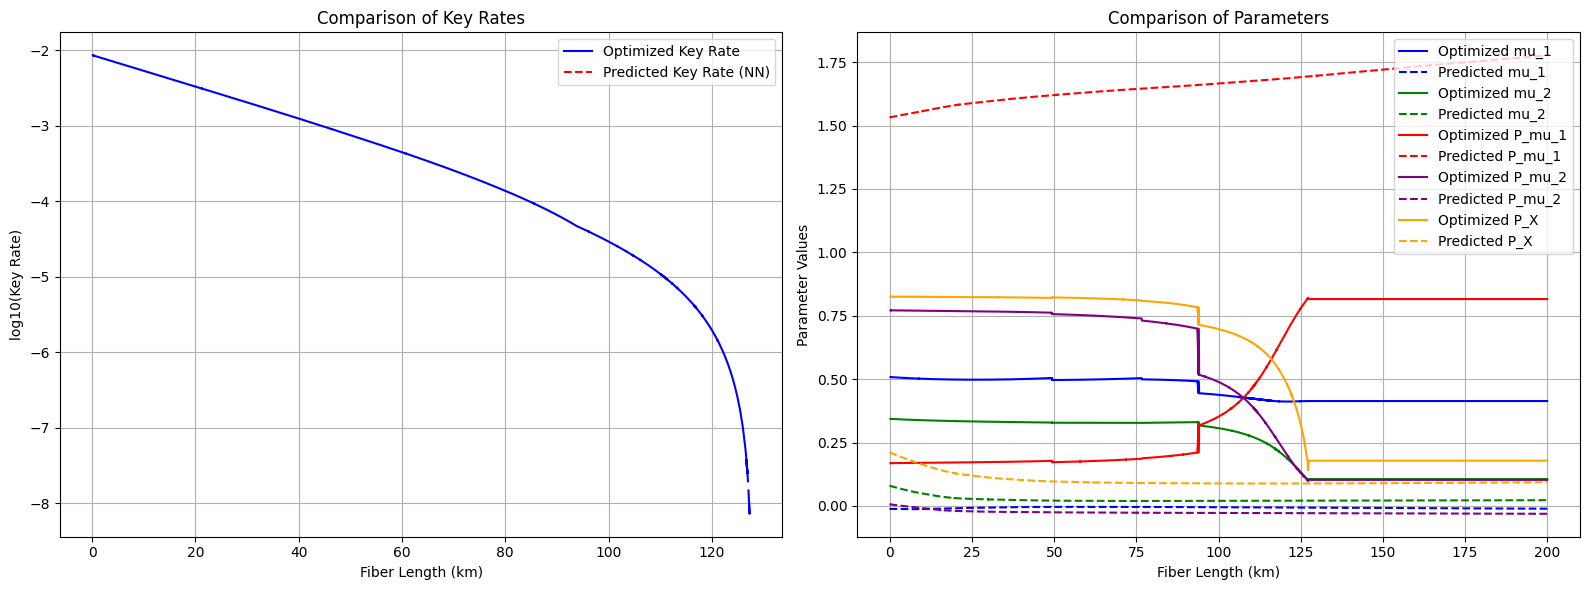

In [24]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from QKD_Functions.QKD_Functions import objective

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = BB84NN().to(device)
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Load the dataset
with open("../Training_Data/single_nx/qkd_grouped_dataset_20250213_110036.json", 'r') as f:
    dataset = json.load(f)

# Select an n_X value
target_nx = 1e8
nx_key = str(float(target_nx))
if nx_key not in dataset:
    raise ValueError(f"No data found for n_X = {target_nx}")

optimized_data = dataset[nx_key]

# Extract fiber lengths, optimized key rates, and parameters
fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])
optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

# Predict parameters and key rates
predicted_params_list = []
predicted_key_rates = []
for L in fiber_lengths:
    e_1 = L / 100
    e_2 = -np.log10(6e-7)
    e_3 = 5e-3 * 100
    e_4 = np.log10(target_nx)
    X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        params = model(X).cpu().numpy()[0]
        predicted_params_list.append(params)
        key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=4e-2, n_event=1)[0]
        predicted_key_rates.append(key_rate)

predicted_params_array = np.array(predicted_params_list)
predicted_key_rates = np.array(predicted_key_rates)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot key rates comparison on the left
ax1.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', label="Predicted Key Rate (NN)")
ax1.set_title('Comparison of Key Rates')
ax1.set_xlabel('Fiber Length (km)')
ax1.set_ylabel('log10(Key Rate)')
ax1.legend()
ax1.grid(True)

# Plot parameters comparison on the right
labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i in range(5):
    ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
    ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', color=colors[i], linestyle='--')

ax2.set_title('Comparison of Parameters')
ax2.set_xlabel('Fiber Length (km)')
ax2.set_ylabel('Parameter Values')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# import json
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from QKD_Functions.QKD_Functions import objective

# # ✅ Load the trained model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BB84NN().to(device)
# checkpoint = torch.load("best_model.pth", map_location=device)
# model.load_state_dict(checkpoint)
# model.eval()

# # ✅ Load the dataset with optimized key rates
# with open("../Training_Data/qkd_grouped_dataset_20250206_173005.json", 'r') as f:
#     dataset = json.load(f)

# # ✅ Select an n_X value to compare (change as needed)
# target_nx = 1e6  # Adjust as needed
# nx_key = str(float(target_nx))

# if nx_key not in dataset:
#     raise ValueError(f"No data found for n_X = {target_nx}")

# optimized_data = dataset[nx_key]  # Extract data for the selected n_X

# # ✅ Extract fiber lengths and optimized key rates
# fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
# optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])

# # ✅ Predict parameters using the trained model
# predicted_params_list = []
# predicted_key_rates = []

# for L in fiber_lengths:
#     e_1 = L / 100  # Normalized fiber length
#     e_2 = -np.log10(6e-7)  # Dark count processing (P_dc_value = 6e-7)
#     e_3 = 5e-3 * 100  # Misalignment error
#     e_4 = np.log10(target_nx)  # Log-transformed detected events

#     # Construct input tensor
#     X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)

#     # Perform prediction
#     with torch.no_grad():
#         params = model(X).cpu().numpy()[0]
#         predicted_params_list.append(params)

#     # ✅ Calculate key rate using objective function
#     key_rate = objective(
#         params,  # Predicted parameters
#         L,       # Current fiber length
#         target_nx,
#         alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7,
#         epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16,
#         e_mis=5e-3, P_ap=4e-2, n_event=1
#     )[0]  # Extract key rate from the objective output

#     predicted_key_rates.append(key_rate)

# # ✅ Convert predicted key rates to numpy array
# predicted_key_rates = np.array(predicted_key_rates)

# # ✅ Plot the comparison
# plt.figure(figsize=(12, 6))

# plt.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
# plt.plot(fiber_lengths, np.log10(predicted_key_rates), 'r:', label="Predicted Key Rate (NN)")

# plt.xlabel("Fiber Length (km)")
# plt.ylabel("log10(Key Rate)")
# plt.title(f"Comparison of Key Rates (n_X = {target_nx:.0e})")
# plt.legend()
# plt.grid(True)
# plt.show()

# # ✅ Print sample values for debugging
# print("\nSample Comparison:")
# print("Fiber Length | Optimized Key Rate | Predicted Key Rate")
# print("-" * 60)
# for i in range(0, len(fiber_lengths), max(len(fiber_lengths)//10, 1)):  # Print 10 evenly spaced samples
#     print(f"{fiber_lengths[i]:10.2f} km | {optimized_key_rates[i]:.2e} | {predicted_key_rates[i]:.2e}")

In [ ]:
# import json
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_for_nx(data, target_nx):
#     """
#     Plot results for a specific n_X value, filtering out zero key rates.
#     """
#     # Convert to string for dictionary key lookup
#     target_nx_str = str(float(target_nx))  # Ensure it matches JSON key format

#     # Retrieve data correctly from grouped dictionary
#     if target_nx_str not in data:
#         print(f"No data found for n_X = {target_nx}")
#         return
    
#     filtered_data = data[target_nx_str]  # Get the list of entries
    
#     # Filter out key rates that are zero or too small
#     filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  # Adjust threshold if needed

#     if not filtered_data:
#         print(f"No non-zero key rates found for n_X = {target_nx}")
#         return

#     # Extract data
#     fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
#     key_rates = [entry["key_rate"] for entry in filtered_data]

#     # ✅ Improved visualization
#     plt.figure(figsize=(12, 6))
    
#     # ✅ Key Rate vs Fiber Length
#     plt.subplot(1, 2, 1)
#     plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', color='b', label="Key Rate")
#     plt.xlabel("Fiber Length (km)")
#     plt.ylabel("log10(Key Rate)")
#     plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
#     plt.legend()
#     plt.grid(True)
    
#     # ✅ Optimized Parameters vs Fiber Length
#     plt.subplot(1, 2, 2)
#     params_names = list(filtered_data[0]["optimized_params"].keys())
#     for param_name in params_names:
#         params_values = [entry["optimized_params"][param_name] for entry in filtered_data]
#         plt.plot(fiber_lengths, params_values, linestyle='-', label=param_name)
    
#     plt.xlabel("Fiber Length (km)")
#     plt.ylabel("Parameter Value")
#     plt.title(f"Optimized Parameters vs Fiber Length (n_X = {target_nx:.0e})")
#     plt.legend()
#     plt.ylim(0.0, 1.0)
#     plt.yticks(np.arange(0.0, 1.05, 0.05))
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
#     plt.show()

In [ ]:
# # Load dataset
# with open("../Training_Data/qkd_grouped_dataset_20250206_173005.json", 'r') as f:
#     dataset = json.load(f)

# # Print available n_X values
# print("Available n_X values:", list(dataset.keys())[:5])  # Print first 5 unique n_X values

# # List of n_X values to plot
# n_X_values = [10**s for s in range(4, 10)]  # Generates [10^4, 10^5, ..., 10^9]

# # Loop through n_X values and plot
# for n_X in n_X_values:
#     print(f"\nPlotting results for n_X = {n_X:.0e}")
#     plot_for_nx(dataset, n_X)

In [ ]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from QKD_Functions.QKD_Functions import objective

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "mps")  # Adjust based on your device

model = BB84NN().to(device)
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Load the dataset with optimized key rates and parameters
with open("../Training_Data/qkd_grouped_dataset_20250206_173005.json", 'r') as f:
    dataset = json.load(f)

# Select an n_X value to compare
target_nx = 1e8
nx_key = str(float(target_nx))

if nx_key not in dataset:
    raise ValueError(f"No data found for n_X = {target_nx}")

optimized_data = dataset[nx_key]

# Extract fiber lengths and optimized parameters
fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in optimized_data])

# Predict parameters using the trained model
predicted_params_list = []
for L in fiber_lengths:
    e_1 = L / 100  # Normalized fiber length
    e_2 = -np.log10(6e-7)  # Dark count processing
    e_3 = 5e-3 * 100  # Misalignment error
    e_4 = np.log10(target_nx)  # Log-transformed detected events

    X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)

    with torch.no_grad():
        params = model(X).cpu().numpy()[0]
        predicted_params_list.append(params)

predicted_params_array = np.array(predicted_params_list)

# Plotting both optimized and predicted parameters
plt.figure(figsize=(14, 10))
labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']

for i in range(5):
    plt.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', linestyle='-', markersize=4)
    plt.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', linestyle='--', markersize=4)

plt.title('Comparison of Optimized and Predicted Parameters')
plt.xlabel('Fiber Length (km)')
plt.ylabel('Parameter Values')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_83114/1342507189.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", ma

ValueError: No data found for n_X = 100000000.0

In [ ]:
# for i in range(len(predicted_params_list)):
#     mu_1, mu_2, P_mu_1, P_mu_2, P_X = predicted_params_list[i]

#     # Fixed mu_3 value
#     mu_3 = 2e-4  # Given constant

#     # Ensure constraints are met:
#     if mu_1 <= mu_2 + mu_3:
#         mu_1 = mu_2 + mu_3 + 1e-6  # Adjust to satisfy condition
    
#     if mu_2 / mu_1 >= 1:
#         mu_2 = 0.99 * mu_1  # Slightly reduce mu_2 to satisfy ratio condition

#     P_mu_3 = max(1 - (P_mu_1 + P_mu_2), 1e-6)  # Ensure P_mu_3 > 0
#     P_Z = max(1 - P_X, 1e-6)  # Ensure non-negative probability

#     # Re-apply constraints for consistency
#     if P_mu_1 + P_mu_2 + P_mu_3 > 1:
#         P_mu_1 /= (P_mu_1 + P_mu_2 + P_mu_3)
#         P_mu_2 /= (P_mu_1 + P_mu_2 + P_mu_3)
#         P_mu_3 = 1 - P_mu_1 - P_mu_2  # Adjusted sum exactly to 1

#     if mu_2 <= mu_3:
#         mu_2 = mu_3 + 1e-6  # Ensure mu_2 > mu_3

#     # Store corrected parameters
#     predicted_params_list[i] = [mu_1, mu_2, P_mu_1, P_mu_2, P_X, P_mu_3, P_Z]

# print("✅ Constraints have been enforced on all predicted parameters.")

In [ ]:
# import json
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from QKD_Functions.QKD_Functions import objective

# # ✅ Load the trained model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BB84NN().to(device)
# checkpoint = torch.load("best_model.pth", map_location=device)
# model.load_state_dict(checkpoint)
# model.eval()

# # ✅ Load the dataset with optimized key rates
# with open("../Training_Data/qkd_grouped_dataset_20250206_173005.json", 'r') as f:
#     dataset = json.load(f)

# # ✅ Select an n_X value to compare (change as needed)
# target_nx = 1e6  # Adjust as needed
# nx_key = str(float(target_nx))

# if nx_key not in dataset:
#     raise ValueError(f"No data found for n_X = {target_nx}")

# optimized_data = dataset[nx_key]  # Extract data for the selected n_X

# # ✅ Extract fiber lengths and optimized key rates
# fiber_lengths = np.array([entry["fiber_length"] for entry in optimized_data])
# optimized_key_rates = np.array([entry["key_rate"] for entry in optimized_data])

# # ✅ Predict parameters using the trained model
# predicted_params_list = []
# predicted_key_rates = []

# for L in fiber_lengths:
#     e_1 = L / 100  # Normalized fiber length
#     e_2 = -np.log10(6e-7)  # Dark count processing (P_dc_value = 6e-7)
#     e_3 = 5e-3 * 100  # Misalignment error
#     e_4 = np.log10(target_nx)  # Log-transformed detected events

#     # Construct input tensor
#     X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)

#     # Perform prediction
#     with torch.no_grad():
#         params = model(X).cpu().numpy()[0]
#         predicted_params_list.append(params)

#     # ✅ Calculate key rate using objective function
#     key_rate = objective(
#         params,  # Predicted parameters
#         L,       # Current fiber length
#         target_nx,
#         alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7,
#         epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16,
#         e_mis=5e-3, P_ap=4e-2, n_event=1
#     )[0]  # Extract key rate from the objective output

#     predicted_key_rates.append(key_rate)

# # ✅ Convert predicted key rates to numpy array
# predicted_key_rates = np.array(predicted_key_rates)

# # ✅ Plot the comparison
# plt.figure(figsize=(12, 6))

# plt.plot(fiber_lengths, np.log10(optimized_key_rates), 'b-', label="Optimized Key Rate")
# plt.plot(fiber_lengths, np.log10(predicted_key_rates), 'r:', label="Predicted Key Rate (NN)")

# plt.xlabel("Fiber Length (km)")
# plt.ylabel("log10(Key Rate)")
# plt.title(f"Comparison of Key Rates (n_X = {target_nx:.0e})")
# plt.legend()
# plt.grid(True)
# plt.show()

# # ✅ Print sample values for debugging
# print("\nSample Comparison:")
# print("Fiber Length | Optimized Key Rate | Predicted Key Rate")
# print("-" * 60)
# for i in range(0, len(fiber_lengths), max(len(fiber_lengths)//10, 1)):  # Print 10 evenly spaced samples
#     print(f"{fiber_lengths[i]:10.2f} km | {optimized_key_rates[i]:.2e} | {predicted_key_rates[i]:.2e}")

In [ ]:
    
#     # Store all results
#     predicted_key_rates.append(penalized_key_rate)
#     eta_ch_list.append(eta_ch)
#     S_X_0_list.append(S_X_0)
#     S_Z_0_list.append(S_Z_0)
#     S_X_1_list.append(S_X_1)
#     S_Z_1_list.append(S_Z_1)
#     tau_0_list.append(tau_0)
#     tau_1_list.append(tau_1)
#     e_mu_k_list.append(e_mu_k)
#     e_obs_X_list.append(e_obs_X)
#     v_Z_1_list.append(v_Z_1)
#     gamma_list.append(gamma)
#     Phi_X_list.append(Phi_X)
#     binary_entropy_Phi_list.append(binary_entropy_Phi)
#     lambda_EC_list.append(lambda_EC)
#     l_calculated_list.append(l_calculated)

# # Convert to numpy arrays
# predicted_params_array = np.array(predicted_params_list)

# # Create multiple subplots for all the metrics
# plt.figure(figsize=(20, 25))

# # Plot 1: Key Rate
# plt.subplot(5, 2, 1)
# plt.plot(fiber_lengths, predicted_key_rates, 'b-', label='Key Rate')
# plt.xlabel('Fiber Length (km)')
# plt.ylabel('Key Rate')
# plt.yscale('log')
# plt.title('Predicted Key Rate')
# plt.grid(True)
# plt.legend()

# # Plot 2: Parameters
# plt.subplot(5, 2, 2)
# param_names = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X_value']
# for i in range(5):
#     plt.plot(fiber_lengths, predicted_params_array[:, i], label=param_names[i])
# plt.xlabel('Fiber Length (km)')
# plt.ylabel('Parameter Value')
# plt.title('Predicted Parameters')
# plt.grid(True)
# plt.legend()

# # Plot additional metrics
# metrics = [
#     (eta_ch_list, 'Channel Transmittance'),
#     (S_X_0_list, 'S_X_0'),
#     (S_Z_0_list, 'S_Z_0'),
#     (tau_0_list, 'tau_0'),
#     (e_obs_X_list, 'e_obs_X'),
#     (v_Z_1_list, 'v_Z_1'),
#     (gamma_list, 'gamma'),
#     (l_calculated_list, 'l_calculated')
# ]

# for i, (metric, title) in enumerate(metrics, 3):
#     plt.subplot(5, 2, i)
#     plt.plot(fiber_lengths, metric, 'g-')
#     plt.xlabel('Fiber Length (km)')
#     plt.ylabel(title)
#     plt.title(title)
#     plt.grid(True)

# plt.tight_layout()
# plt.savefig('comprehensive_predictions_nx_1e12.png')
# plt.show()

# # Print some values at specific distances
# distances = [0,20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
# print("\nPredicted Values at Specific Distances:")
# print("Distance (km) | Key Rate | eta_ch | S_X_0 | e_obs_X")
# print("-" * 60)
# for d in distances:
#     idx = np.abs(fiber_lengths - d).argmin()
#     print(f"{d:11.0f} | {predicted_key_rates[idx]:8.2e} | {eta_ch_list[idx]:6.4f} | {S_X_0_list[idx]:6.4f} | {e_obs_X_list[idx]:6.4f}")

By looking at a small number of predictions and comparing them with the ground truth, verify if the network is producing reasonable outputs (e.g., no extreme or unrealistic values). 


If the predictions look incorrect (e.g., constant values, extreme outliers, or all zeros), adjust the training process accordingly.


	1.	sample_predictions:
	•	This contains the predictions for the first 10 samples from the validation dataset (X_val[:10]).
	•	It helps seeing the model’s behavior for a subset of the data.
	2.	Y_val[:10]:
	•	Ground truth values corresponding to the same subset.
	3.	Why Add This?
	•	If the predictions are drastically different from the ground truth or have unexpected behavior (e.g., constant predictions, all zeros, or extreme values), it can indicate issues in:
	•	Network architecture.
	•	Data preprocessing (e.g., scaling).
	•	Training process (e.g., learning rate, exploding gradients).


In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from QKD_Functions.QKD_Functions import objective  # Make sure this is imported

# # Load the trained model correctly
# model = BB84NN().to(device)
# checkpoint = torch.load('best_model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

# # Fixed parameters for key rate calculation
# alpha = 0.2
# eta_Bob = 0.1
# P_dc_value = 6e-7
# epsilon_sec = 1e-10
# epsilon_cor = 1e-15
# f_EC = 1.16
# e_mis = 5e-3
# P_ap = 4e-2
# n_event = 1

# # Set n_X = 10^12
# target_nx = 1e12
# e_4 = np.log10(target_nx)

# # Generate fiber lengths
# fiber_lengths = np.linspace(0.1, 200, 1000)

# # Lists to store results
# predicted_key_rates = []
# predicted_params_list = []

# # For each fiber length
# for L in fiber_lengths:
#     # Prepare input for neural network
#     e_1 = L / 100
#     e_2 = -np.log10(P_dc_value)
#     e_3 = e_mis * 100
    
#     # Neural network input
#     X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    
#     # Get predicted parameters
#     with torch.no_grad():
#         params = model(X).cpu().numpy()[0]
#         predicted_params_list.append(params)
    
#     # Calculate key rate using the objective function
#     key_rate = objective(
#         params,  # predicted parameters
#         L,       # current fiber length
#         target_nx,
#         alpha, eta_Bob, P_dc_value, 
#         epsilon_sec, epsilon_cor, f_EC, 
#         e_mis, P_ap, n_event
#     )[0]  # Get first element which is the key rate
    
#     predicted_key_rates.append(key_rate)

# # Convert to numpy arrays
# predicted_params_array = np.array(predicted_params_list)
# predicted_key_rates = np.array(predicted_key_rates)

# # Plotting
# plt.figure(figsize=(15, 10))

# # Plot 1: Key Rate
# plt.subplot(2, 1, 1)
# plt.plot(fiber_lengths, predicted_key_rates, 'b-', label='Predicted Key Rate')
# plt.xlabel('Fiber Length (km)', fontsize=14)
# plt.ylabel('Key Rate', fontsize=14)
# plt.title(f'Predicted Key Rate for n_X = {target_nx:.0e}', fontsize=16)
# plt.yscale('log')
# plt.ylim(1e-11, 1e-6)
# plt.grid(True)
# plt.legend()

# # Plot 2: Parameters
# plt.subplot(2, 1, 2)
# param_names = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X_value']
# for i in range(5):
#     plt.plot(fiber_lengths, predicted_params_array[:, i], label=param_names[i])
# plt.xlabel('Fiber Length (km)', fontsize=14)
# plt.ylabel('Parameter Value', fontsize=14)
# plt.title('Predicted Parameters vs Fiber Length', fontsize=16)
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.savefig('predictions_nx_1e12.png')
# plt.show()

# # Print some values at specific distances
# distances = [0, 50, 100, 150, 200]
# print("\nPredicted Values at Specific Distances:")
# print("Distance (km) |    mu_1    |    mu_2    |   P_mu_1   |   P_mu_2   | P_X_value  | Key Rate")
# print("-" * 95)
# for d in distances:
#     idx = np.abs(fiber_lengths - d).argmin()
#     params = predicted_params_array[idx]
#     key_rate = predicted_key_rates[idx]
#     print(f"{d:11.0f} | {params[0]:9.6f} | {params[1]:9.6f} | {params[2]:9.6f} | {params[3]:9.6f} | {params[4]:9.6f} | {key_rate:.2e}")

In [ ]:
# # Import necessary libraries
# import torch
# import numpy as np
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# # from QKD_Functions.QKD_Functions import compute_loss, objective  # Ensure this is imported correctly

# def compute_loss(predictions, targets, bounds):
#     # Calculate standard loss (e.g., MSE)
#     loss = criterion(predictions, targets)
    
#     # Add penalties for out-of-bounds predictions
#     lower_penalties = torch.sum(torch.relu(1e-4 - predictions[:, :2]))  # For mu_1 and mu_2
#     upper_penalties = torch.sum(torch.relu(predictions - 1))            # For mu_1 and mu_2
#     loss += 0.1 * (lower_penalties + upper_penalties)
    
#     return loss

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Fixed parameters
# alpha = 0.2
# eta_Bob = 0.1
# P_dc_value = 6e-7
# epsilon_sec = 1e-10
# epsilon_cor = 1e-15
# f_EC = 1.16
# e_mis = 5e-3
# P_ap = 4e-2
# n_event = 1

# # Define the model architecture (ensure this is correctly defined)
# class BB84NN(torch.nn.Module):
#     def __init__(self):
#         super(BB84NN, self).__init__()
#         # Example layers, adjust as needed
#         self.fc1 = torch.nn.Linear(4, 64)
#         self.fc2 = torch.nn.Linear(64, 32)
#         self.fc3 = torch.nn.Linear(32, 5)  # Assuming 5 parameters to predict

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         return self.fc3(x)

# # Initialize the model and move it to the device
# model = BB84NN().to(device)

# # Define loss function and optimizer
# criterion = compute_loss  # Custom loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# grad_clip_norm = 1.0

# # Load training data (ensure this is correctly loaded)
# X_train, Y_train = load_training_data()  # Implement this function
# X_val, Y_val = load_validation_data()    # Implement this function

# # Data preprocessing
# scaler_X = StandardScaler()
# scaler_Y = MinMaxScaler()

# X_train_scaled = scaler_X.fit_transform(X_train)
# X_val_scaled = scaler_X.transform(X_val)

# Y_train_scaled = scaler_Y.fit_transform(Y_train)
# Y_val_scaled = scaler_Y.transform(Y_val)

# # Convert data to PyTorch tensors
# train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), 
#                                                torch.tensor(Y_train_scaled, dtype=torch.float32))
# val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), 
#                                              torch.tensor(Y_val_scaled, dtype=torch.float32))

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# # Training loop
# num_epochs = 1000
# patience = 20
# best_val_loss = float('inf')
# no_improvement_count = 0

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
    
#     for batch_X, batch_Y in train_loader:
#         batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        
#         # Forward pass
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_Y)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
#         optimizer.step()
        
#         train_loss += loss.item()
    
#     avg_train_loss = train_loss / len(train_loader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
#     # Validation
#     model.eval()
#     val_loss = 0.0
    
#     with torch.no_grad():
#         for batch_X, batch_Y in val_loader:
#             batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_Y)
            
#             val_loss += loss.item()
    
#     avg_val_loss = val_loss / len(val_loader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}')
    
#     # Early stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         no_improvement_count = 0
        
#         # Save the model
#         torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict()
#         }, 'best_model.pth')
#     else:
#         no_improvement_count += 1
#         if no_improvement_count >= patience:
#             print("Early stopping triggered.")
#             break

# # Load the best model for evaluation
# model = BB84NN().to(device)
# checkpoint = torch.load('best_model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

# # Define fiber length range and fixed n_X value
# fiber_lengths = np.linspace(0.1, 200, 1000)  # Fiber lengths from 0.1 km to 200 km
# target_nx = 1e13  # Fixed n_X value

# # Prepare inputs for the neural network
# predicted_params_list = []
# predicted_key_rates = []

# for L in fiber_lengths:
#     e_1 = L / 100  # Normalized fiber length
#     e_2 = -np.log10(P_dc_value)  # Dark count processing
#     e_3 = e_mis * 100  # Misalignment error
#     e_4 = np.log10(target_nx)  # Log-scaled detected events
    
#     # Construct input tensor
#     X = torch.tensor([[e_1, e_2, e_3, e_4]], dtype=torch.float32).to(device)
    
#     # Perform prediction
#     with torch.no_grad():
#         params = model(X).cpu().numpy()[0]
#         predicted_params_list.append(params)
    
#     # Calculate all values using objective function
#     result = objective(
#         params,  # predicted parameters
#         L,       # current fiber length
#         target_nx,
#         alpha, eta_Bob, P_dc_value, 
#         epsilon_sec, epsilon_cor, f_EC, 
#         e_mis, P_ap, n_event
#     )
    
#     # Unpack all results
#     (penalized_key_rate, eta_ch, S_X_0, S_Z_0, S_X_1, S_Z_1, 
#      tau_0, tau_1, e_mu_k, e_obs_X, v_Z_1, gamma, Phi_X,
#      binary_entropy_Phi, lambda_EC, l_calculated) = result
    
#     # Store all results
#     predicted_key_rates.append(penalized_key_rate)

# # Convert predicted parameters to numpy array
# predicted_params_array = np.array(predicted_params_list)
# predicted_key_rates_array = np.array(predicted_key_rates)

# # Sample predictions for verification
# sample_predictions = scaler_Y.inverse_transform(model(torch.tensor(X_val_scaled[:10], dtype=torch.float32).to(device)).cpu().numpy())
# ground_truth = scaler_Y.inverse_transform(Y_val_scaled[:10])

# print("Sample Predictions:\n", sample_predictions)
# print("Ground Truth:\n", ground_truth)

# # Plotting (optional)
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 7))
# plt.plot(fiber_lengths, predicted_key_rates_array, label='Predicted Key Rate')
# plt.xlabel('Fiber Length (km)')
# plt.ylabel('Key Rate')
# plt.title('Predicted Key Rate vs Fiber Length')
# plt.legend()
# plt.show()


In [ ]:
# # Step 2: Load and Plot Dataset
# def plot_for_nx(data, target_nx):
#     """
#     Plot results for a specific n_X value
#     """
#     # Convert target_nx to string for dictionary key
#     nx_key = str(float(target_nx))
    
#     if nx_key not in data:
#         print(f"No data found for n_X = {target_nx}")
#         return
        
#     filtered_data = data[nx_key]
    
#     if not filtered_data:
#         print(f"No valid results for n_X = {target_nx}")
#         return
    
#     # Extract data
#     fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
#     key_rates = [entry["key_rate"] for entry in filtered_data]
    
#     # Create figure
#     plt.figure(figsize=(15, 6))
    
#     # Plot key rates
#     plt.subplot(1, 2, 1)
#     plt.plot(fiber_lengths, np.log10([max(kr, 1e-30) for kr in key_rates]))
#     plt.xlabel("Fiber Length (km)")
#     plt.ylabel("log10(Key Rate)")
#     plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
#     plt.grid(True)
    
#     # Plot parameters
#     plt.subplot(1, 2, 2)
#     params = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]
#     for param in params:
#         values = [entry["optimized_params"][param] for entry in filtered_data]
#         plt.plot(fiber_lengths, values, label=param)
    
#     plt.xlabel("Fiber Length (km)")
#     plt.ylabel("Parameter Value")
#     plt.title(f"Optimized Parameters (n_X = {target_nx:.0e})")
#     plt.legend()
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
#     plt.show()

# # # Load the saved dataset
# # with open("qkd_dataset_high_nx.json", 'r') as f:
# #     dataset = json.load(f)

# # Load the saved dataset
# with open("../Training_Data/qkd_dataset_comprehensive_20250122_004748.json", 'r') as f:
#     dataset = json.load(f)

# # Plot results for each n_X value
# for nx in [10**s for s in range(11, 15, 1)]:
#     print(f"\nPlotting results for n_X = {nx:.0e}")
#     plot_for_nx(dataset, nx)

In [ ]:
# Load and filter data for specific n_X (10^12)
with open("../Training_Data/qkd_dataset_comprehensive_20250122_004740.json", "r") as f:
    dataset = json.load(f)

target_nx = "1e8"  # or "1000000000000.0" depending on your data format
filtered_data = []

# Handle the dictionary structure where n_X values are keys
if isinstance(dataset, dict):
    # Get data for specific n_X
    for n_x_key, entries in dataset.items():
        if float(n_x_key) == 1e12:  # Check for 10^12
            filtered_data.extend(entries)

print(f"Number of entries for n_X = 10^12: {len(filtered_data)}")

# Plot comparison for n_X = 10^12
plt.figure(figsize=(12, 8))

# Extract data for plotting
fiber_lengths = [entry['fiber_length'] for entry in filtered_data]
optimal_key_rates = [entry['key_rate'] for entry in filtered_data]

# Get predictions for the same fiber lengths
test_inputs = []
for entry in filtered_data:
    test_inputs.append([
        entry['e_1'],
        entry['e_2'],
        entry['e_3'],
        entry['e_4']
    ])

# Convert to tensor and get predictions
test_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    predictions = model(test_tensor).cpu().numpy()

# Plot results
plt.subplot(2, 1, 1)
plt.plot(fiber_lengths, np.log10(optimal_key_rates), 'b-', label='Optimal Key Rate')
plt.plot(fiber_lengths, np.log10(predictions[:, 0]), 'r--', label='Predicted Key Rate')
plt.xlabel('Fiber Length (km)')
plt.ylabel('log10(Key Rate)')
plt.title('Key Rate Comparison for n_X = 10^12')
plt.legend()
plt.grid(True)

# Plot parameters
plt.subplot(2, 1, 2)
param_names = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X_value']
optimal_params = np.array([list(entry['optimized_params'].values()) for entry in filtered_data])
predicted_params = predictions[:, 1:]  # Skip key rate column

for i in range(5):
    plt.plot(fiber_lengths, optimal_params[:, i], '-', label=f'Optimal {param_names[i]}')
    plt.plot(fiber_lengths, predicted_params[:, i], '--', label=f'Predicted {param_names[i]}')

plt.xlabel('Fiber Length (km)')
plt.ylabel('Parameter Value')
plt.title('Parameter Comparison for n_X = 10^12')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nStatistics for n_X = 10^12:")
mse_key_rate = np.mean((np.log10(optimal_key_rates) - np.log10(predictions[:, 0]))**2)
print(f"MSE for log10(Key Rate): {mse_key_rate:.6f}")

for i in range(5):
    mse_param = np.mean((optimal_params[:, i] - predicted_params[:, i])**2)
    print(f"MSE for {param_names[i]}: {mse_param:.6f}")

In [ ]:

# Load the training dataset for the optimal key rates and parameters

# Load the dataset
with open("../Training_Data/total_training_dataset.json", "r") as f:
    dataset = json.load(f)

# Filter for n_X = 10^6 (e_4 = log10(10^6) = 6)
filtered_data = [entry for entry in dataset if np.isclose(entry["e_4"], 6, atol=1e-2)]

print(f"Number of entries for n_X = 10^6: {len(filtered_data)}")

# Extract fiber lengths and optimized parameters
Ls_training = np.array([item["e_1"] * 100 for item in training_data])  # Convert normalized to km
optimal_params = np.array([item["optimized_params"] for item in training_data])  # Extract optimal parameters

# Load the best model
model.load_state_dict(torch.load("best_model.pth")['model_state_dict'])
model.eval()

# Make predictions on validation data

with torch.no_grad():
    predicted_Y = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()

    # Debugging: Check a few sample predictions
    sample_predictions = model(torch.tensor(X_val[:10], dtype=torch.float32).to(device)).cpu().numpy()
    print("Sample Predictions:\n", sample_predictions)
    print("Sample Ground Truth:\n", Y_val[:10])

# Extract distances (fiber lengths) from validation set
distances_km = X_val[:, 0] * 100  # Convert normalized distance back to km

# Convert normalized e_1 back to kilometers and clip negatives
distances_km = np.clip(X_val[:, 0] * 100, a_min=0, a_max=None)  # Ensure no negative distances
Ls_training = np.clip([item["e_1"] * 100 for item in training_data], a_min=0, a_max=None)

plt.figure(figsize=(10, 6))
# Plot the line for the optimal key rate from the training dataset
plt.plot(Ls, np.log10(optimal_key_rates), 'b-', label="Optimal (Training Dataset)")

# Plot the predicted key rates for validation data
plt.scatter(distances_km, np.log10(key_rate_predicted), color='r', label="NN Predicted", alpha=0.5)

plt.xlabel("Fiber Length (km)")
plt.ylabel("log_{10}(Key Rate)")
plt.title("Key Rate vs Distance")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot 2: Parameter Comparison ----
plt.figure(figsize=(10, 6))
# Extract optimized parameters from the training data
optimized_params = np.array([list(item["optimized_params"].values()) for item in training_data], dtype=np.float32)

plt.figure(figsize=(10, 6))

for i in range(5):  # For each parameter
    # Extract parameter values for plotting
    optimized_values = optimized_params[:, i]  # Optimal parameters from training data
    predicted_values = predicted_Y[:, i]  # Predicted parameters from NN

    # Plot the optimal parameter as a line across all distances
    plt.plot(Ls_training, optimized_values, label=f"Optimized Param {i+1}", linestyle='--')

    # Plot the predicted parameter as points across validation distances
    plt.scatter(distances_km, predicted_values, label=f"NN Predicted Param {i+1}", alpha=0.5)

plt.xlabel("Fiber Length (km)")
plt.ylabel("Parameter Value")
plt.title("Predicted vs Optimal Parameters Across Distance")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# import torch

# # --- Step 1: Load the dataset and filter for n_X = 10^6 ---
# with open("../Training_Data/total_training_dataset.json", "r") as f:
#     dataset = json.load(f)

# # Filter dataset for n_X = 10^6 (e_4 = log10(10^6) = 6)
# filtered_data = [entry for entry in dataset if np.isclose(entry["e_4"], 6, atol=1e-2)]
# print(f"Number of entries for n_X = 10^6: {len(filtered_data)}")

# # Extract fiber lengths (e_1 in km) and optimal key rates
# fiber_lengths_km = np.array([entry["e_1"] * 100 for entry in filtered_data])  # Convert normalized to km
# optimal_key_rates = np.array([entry["key_rate"] for entry in filtered_data])  # Optimal key rates

# # Extract optimal parameters
# optimal_params = np.array([list(entry["optimized_params"].values()) for entry in filtered_data], dtype=np.float32)

# # --- Step 2: Load the trained model and make predictions ---
# # Load the trained model
# model = BB84NN()
# state_dict = torch.load("best_model.pth")['model_state_dict']  # Load the state dictionary
# model.load_state_dict(state_dict)  # Load the state dictionary into the model
# model.eval()

# # Prepare input features for filtered data
# X_filtered = np.array([[entry["e_1"], entry["e_2"], entry["e_3"], entry["e_4"]] for entry in filtered_data])
# X_filtered_tensor = torch.tensor(X_filtered, dtype=torch.float32)

# # Make predictions
# with torch.no_grad():
#     predicted_Y = model(X_filtered_tensor).numpy()

# predicted_key_rates = predicted_Y[:, 0]  # First output is the predicted key rate
# predicted_params = predicted_Y[:, 1:]   # Remaining outputs are the predicted parameters

# # --- Step 3: Plot Key Rate Comparisons ---
# plt.figure(figsize=(10, 6))
# plt.plot(fiber_lengths_km, np.log10(optimal_key_rates), 'b-', label="Optimal Key Rate (log10)", linewidth=2)
# plt.scatter(fiber_lengths_km, np.log10(predicted_key_rates), color='r', label="Predicted Key Rate (log10)", alpha=0.5)
# plt.xlabel("Fiber Length (km)")
# plt.ylabel("log10(Key Rate)")
# plt.title("Key Rate vs Fiber Length (n_X = 10^6)")
# plt.legend()
# plt.grid(True)
# plt.show()

# # --- Step 4: Plot Parameter Comparisons ---
# plt.figure(figsize=(12, 8))
# param_names = ["mu_1", "mu_2", "P_mu_1", "P_mu_2", "P_X_value"]

# for i in range(optimal_params.shape[1]):  # Iterate over parameters
#     plt.plot(fiber_lengths_km, optimal_params[:, i], label=f"Optimal {param_names[i]}", linestyle='--', linewidth=2)
#     plt.scatter(fiber_lengths_km, predicted_params[:, i], label=f"Predicted {param_names[i]}", alpha=0.5)

# plt.xlabel("Fiber Length (km)")
# plt.ylabel("Parameter Value")
# plt.title("Predicted vs Optimal Parameters Across Fiber Length (n_X = 10^6)")
# plt.legend()
# plt.grid(True)
# plt.show()

Plot the features and targets (X_train and Y_train) to ensure there is a meaningful relationship to learn:

In [ ]:
# plt.scatter(X_train[:, 0], Y_train[:, 0])
# plt.xlabel("Feature 1")
# plt.ylabel("Target Param 1")
# plt.title("Feature vs Target")
# plt.show()

Print the ranges of the preprocessed inputs (e_1, e_2, e_3, e_4) to confirm they align with the expected ranges

In [ ]:
# print("Input Feature Ranges:")
# print(f"e_1 (L/100): Min={X[:, 0].min()}, Max={X[:, 0].max()}")
# print(f"e_2 (-log10(Y_0)): Min={X[:, 1].min()}, Max={X[:, 1].max()}")
# print(f"e_3 (e_d * 100): Min={X[:, 2].min()}, Max={X[:, 2].max()}")
# print(f"e_4 (log10(N)): Min={X[:, 3].min()}, Max={X[:, 3].max()}")

Include both training and validation losses in the output for better monitoring:

In [ ]:
# print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

During training, check if tensors and model weights are on the GPU

In [ ]:
# çprint(next(model.parameters()).device)  # Should print 'mps:0' 